<a href="https://colab.research.google.com/github/coderXeno/Customer-Segmentation-ML/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Customer Segmentation***

Customer Segmentation is a process in which we employ various machine learning processes to segment, partition and categorify potential customers into particular groups or sectors or categories in order to employ an advanced business model.

This can consist of sending different advertisements, product recommendations and so on based on their demographic profile, interests, affluence level, previous buying behavior and so on. Customer segmentation is needed for businesses to interact more meaningfully with their target audiences and provide them with a more time-saving and meaningful experience, which again leads to a direct increment in the business revenue.

There are many unsupervised machine learning algorithms that can help companies identify their user base and create consumer segments.

In this project, I have used the K Means Clustering Algorithm which takes in unlabelled data from a dataset and assigns each data point to clusters. The goal of K-Means is to group all the data available into non-overlapping sub-groups that are distinct from each other. 

Here, each sub-group or cluster consists of properties or features that distinguish them from other clusters.

# Process Employed
1.  Download the dataset
2.  Creating an RFM Table
3.  Feature Scaling
4.  Clustering the data
5.  Interpreting the result



# *Step 1*: Downloading the Dataset
For this step, I have used the Online Retail Dataset from UCI Machine Learning.
https://archive.ics.uci.edu/ml/index.php

Here is a screenshot of the dataset's first few columns.

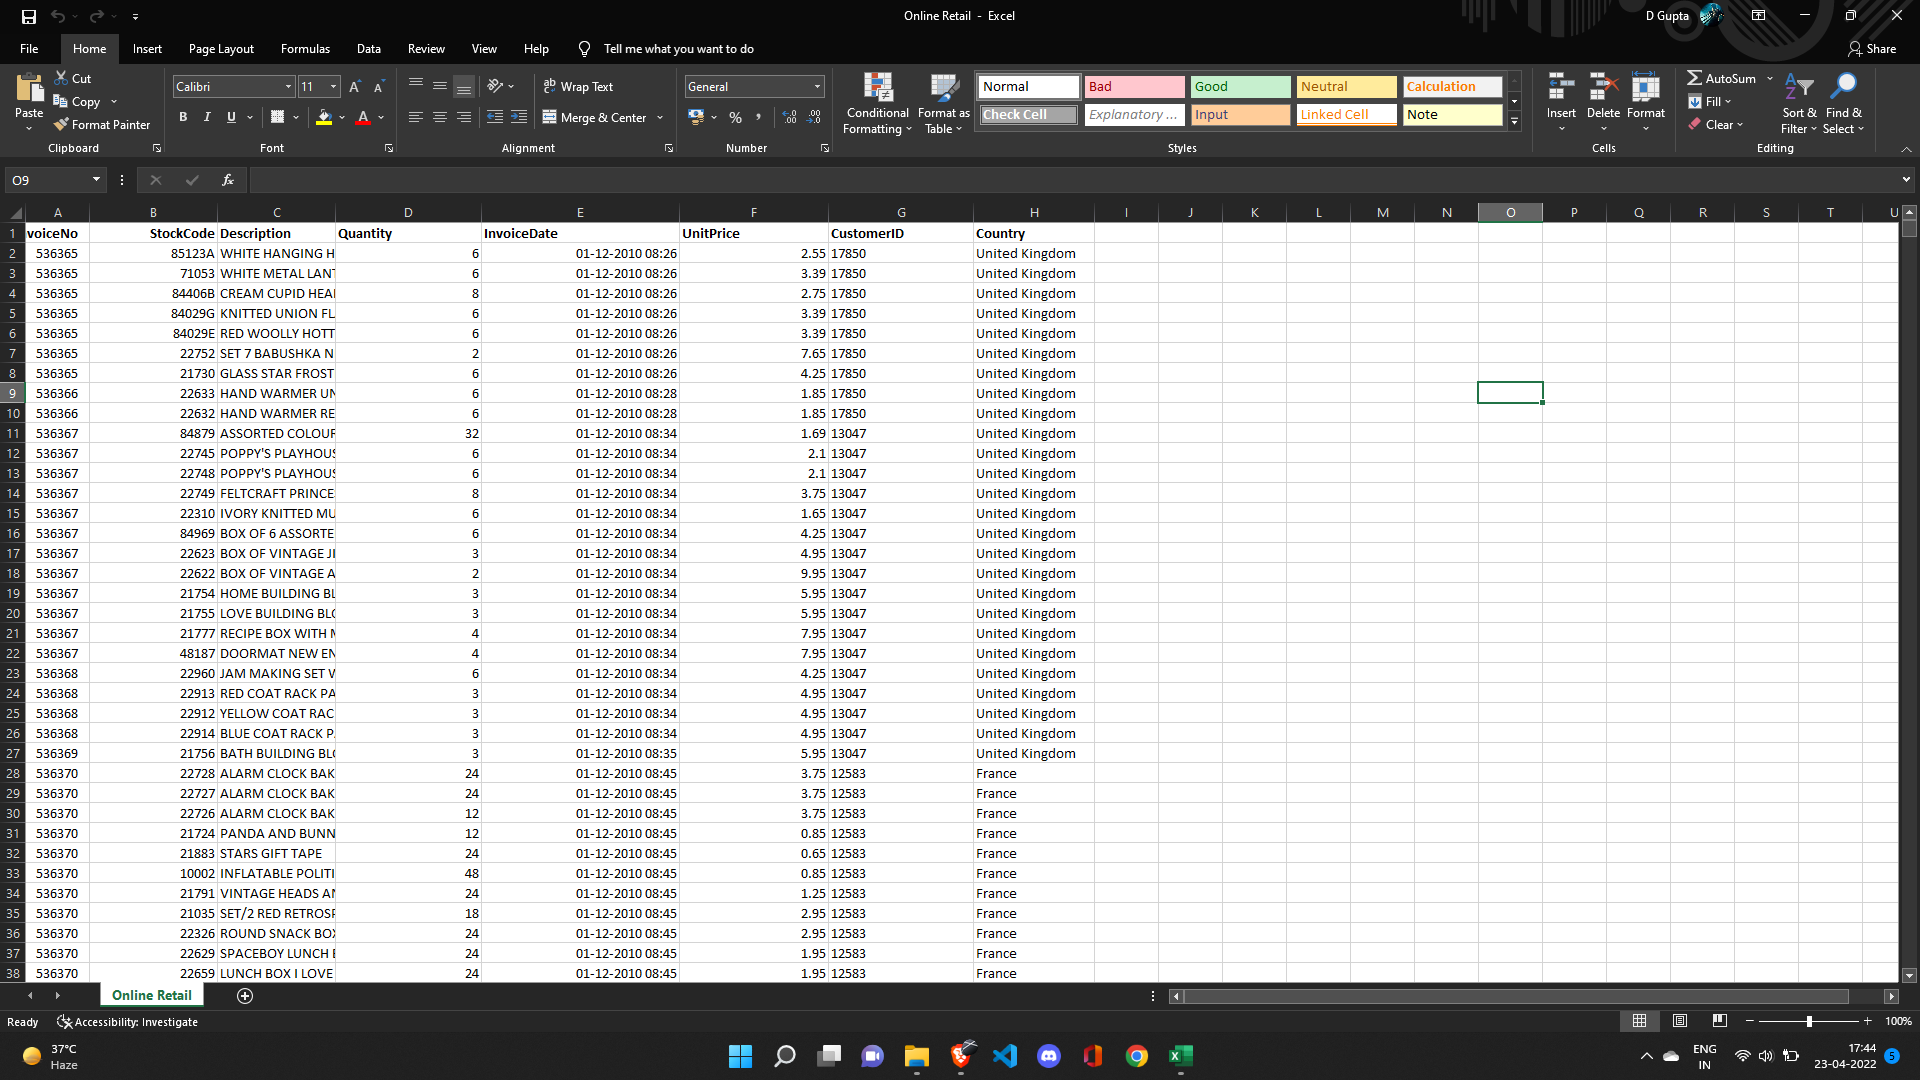

Now, writing down the code for reading the dataset in python and importing some of the required packages.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel('Online Retail.xlsx')
df = df[df['CustomerID'].notna()]

df_fix = df.sample(10000,random_state = 42)



```
# df is the variable which stores the dataset

# the notna() function maps non missing values to True and NA values like None or numpy.NaN get mapped to false
# Then we store the dataset of the true values and omit the false ones.

# .sample always returns a random sample of items from an axis of objects
# here we return 10000 items for our dataset and pass in random_state = 42
# which means we set a constant number as the seed for the random state so that
# no matter how many times we run the code, result stays the same.
```



In [ ]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom


# *Step 2*: Creating an RFM Table

RFM Table or the Recency Frequency Monetary Table is a data driven customer segmentation technique. It segments customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall. All three of these measures have proven to be effective predictors of a customer's willingness to engage in marketing messages and offers.

Using feature transformation, we create a new feature ```TotalSum``` by multiplying two existing features ```Quantity``` and ```UnitPrice```.

In [ ]:
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom,15.9
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom,15.8
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom,-3.4
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom,6.6
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom,13.2


To make the RFM Table, we can create the ```Recency```,```Frequency``` and ```MonetaryValue``` columns.

To get the number of days for the ```Recency``` column, we subtract the date when the transaction occurred from the snapshot date

To create the ```Frequency``` column, we count the number of transactions for each customer.

To create the ```MonetaryValue``` column, we sum all transactions for each customer.

In [ ]:
import datetime
#getting the snapshot date
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

customers = df_fix.groupby(['CustomerID']).agg({
    # getting the Invoice Date for Recency column
    # count - counts number of transactions
    # sum - adds all transactions
    'InvoiceDate':  lambda day: (snapshot_date - day.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

customers.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo':  'Frequency',
    'TotalSum': 'MonetaryValue'
}, inplace = True)
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,39,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,72,5,80.85
12354.0,232,2,33.30
...,...,...,...
18265.0,72,2,39.60
18272.0,2,11,206.17
18274.0,18,2,-4.65


# *Step 3*: Scaling the Features
The data should always meet assumptions where the variables are not skewed and have the same mean and variance.

So, we need to manage skewness of the variables. Here, I have used the box-cox transformation to get the data down to a symmetrical form. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data.



By using the transformation, we will have data that is less skewed. The skewness value declines sharply.

In [ ]:
from scipy import stats

customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers["Recency"])[0]
customers_fix["Frequency"] = stats.boxcox(customers["Frequency"])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values

customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,8.093846,0.591193,3.408514
2686,0.762855,1.435599,5.907565
2687,4.394910,0.591193,-1.669108
2688,1.684124,1.615329,4.273206
2689,6.553285,1.017445,4.087250


Now, each variable doesnt have the same mean and variance, so we need to normalize the data. We use StandardScaler() from scikit-learn to do normalization.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

customers_normalized = scaler.fit_transform(customers_fix)
print(customers_normalized.mean(axis=0).round(2))
print("-------------------------------")
print(customers_normalized.std(axis=0).round(2))

[ 0. -0.  0.]
-------------------------------
[1. 1. 1.]


# *Step 4*: Clustering
In this step, we apply the K-Means Unsupervised Learning Algorithm to make clusters for the data.

The principle of the K Means algorithm is to assign each of the n data points to one of the K clusters where K is a user-defined parameter as the number of clusters desired. The objective is to maximize the homogeneity within the clusters and the difference between the clusters.

By determining each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesnt have significant changes than before.

To make the clustering algorithm reach maximum performance, we have to determine which hyperparameter fits to the data. We use the Elbow Method to determine which hyperparameter is the best for our model and data.

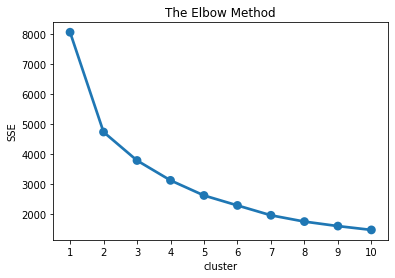

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans

sse = {}

for cluster in range(1,11):
  kmeans = KMeans(n_clusters = cluster, random_state = 42)
  kmeans.fit(customers_normalized)
  sse[cluster] = kmeans.inertia_

plt.title("The Elbow Method")
plt.xlabel('cluster')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the graph, we can see that the k-value of 3 is the best hyperparameter for our model because the next k-value tend to have a linear trend. So, we will use K-Means with the number of clusters is 3.

So, we fit the model.

In [ ]:
model = KMeans(n_clusters = 3, random_state = 42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

By fitting the model, we can have clusters where each data belongs.

# *Step 5*: Interpreting the Segment
We now summarize the RFM Table based on clusters and calculate the mean of each variable.

Using snake plot(normalized dataset and cluster labels), we visualize the cluster differences better.

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(2)

customers

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,39,5,133.20,0
12348.0,249,2,120.88,2
12349.0,19,2,312.75,0
12352.0,72,5,80.85,0
12354.0,232,2,33.30,2
...,...,...,...,...
18265.0,72,2,39.60,1
18272.0,2,11,206.17,0
18274.0,18,2,-4.65,1


In [ ]:
df_normalized = pd.DataFrame(customers_normalized, columns = ['Recency','Frequency','MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

df_normalized

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.496913,1.012426,1.017503,12347.0,0
1,1.234593,-0.017412,0.925115,12348.0,2
2,-0.965883,-0.017412,1.972690,12349.0,0
3,-0.017802,1.012426,0.572565,12352.0,0
4,1.151289,-0.017412,-0.056441,12354.0,2
...,...,...,...,...,...
2685,-0.017802,-0.017412,0.052265,18265.0,1
2686,-1.959623,1.603908,1.472436,18272.0,0
2687,-0.997570,-0.017412,-2.833266,18274.0,1
2688,-1.715598,1.949001,0.543657,18283.0,0


In [ ]:
df_nor_melt = pd.melt(
    df_normalized.reset_index(),
    id_vars = ['ID','Cluster'],
    value_vars = ['Recency','Frequency','MonetaryValue'],
    var_name = 'Attribute',
    value_name = 'Value'
)

In [ ]:
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,0,Recency,-0.496913
1,12348.0,2,Recency,1.234593
2,12349.0,0,Recency,-0.965883
3,12352.0,0,Recency,-0.017802
4,12354.0,2,Recency,1.151289


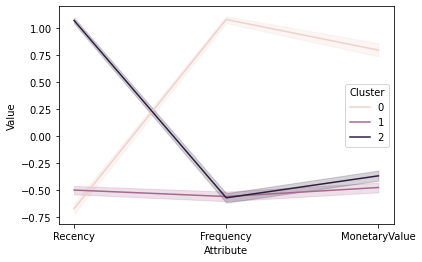

In [ ]:
sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=df_nor_melt)

By using this plot, we know how each segment differs. 

From the graph, we observe that cluster 0 is frequent, spends more and they bought the product recently. Therefore, this cluster could represent the loyal customers.

Cluster 1 is less frequent, has less to spend but they have bought the product recently. So this could be the cluster representing the new customers.

However, Cluster 3 is less frequent, has less to spend and they havent bought the product in a long time. This cluster hence represents the churned customers.

# ***Conclusion***
Customer segmentation can highly enhance business models and increase revenues. Using machine learning algorithms to implement customer segmentation, lets the company go through customer data, analyze and explore it leading to better interactivity and understanding of the customer's wants and needs. Discovering all of the different groups that build up a more meaningful customer base permits us to get into customers’ individual behaviors and give them precisely according to their requirements, enhancing their participation and ultimately expanding profits.